In [1]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [83]:
import pandas as pd
import numpy as np
from data_preparation import PreProcess

preprocess = PreProcess()
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/BBANBDS_21_MACD_12_26_9_AD/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/BBANBDS_21_MACD_12_26_9_AD/test_data.parquet")

Y_Train = df_train.pop("label")
Y_Test = df_test.pop("label")

X_Train = np.array([val[0] for val in df_train.values])
X_Test = np.array([val[0] for val in df_test.values])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60)                18240     
                                                                 
 dense_12 (Dense)            (None, 1)                 61        
                                                                 
Total params: 18,301
Trainable params: 18,301
Non-trainable params: 0
_________________________________________________________________
None


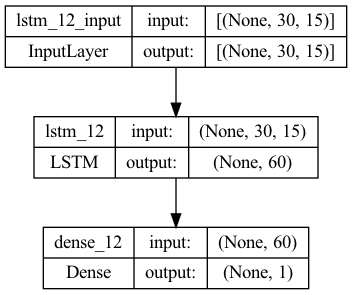

In [84]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Recall, BinaryAccuracy, AUC
import tensorflow as tf
from keras.utils import plot_model


tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(False)

early_stopping = EarlyStopping(monitor='val_auc', 
                               patience=5, 
                               min_delta=0.001, 
                               mode='max')

cp_model_checkpoint = ModelCheckpoint("data/tf_models/benchmark/bacehmark.h5",
                                      monitor='val_auc',
                                      save_best_only=True)

model = Sequential()
model.add(LSTM(60, input_shape=X_Train[0].shape))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[AUC(name='auc')])
model.build(input_shape=X_Train.shape)
print(model.summary())
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

In [85]:
batch_size = 64
epochs = 100

history = model.fit(X_Train, 
                    Y_Train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_Test, Y_Test), 
                    callbacks=[early_stopping, cp_model_checkpoint])
                    
index = history.history['val_auc'].index(max(history.history['val_auc']))
max(history.history['val_auc'])#, history.history['val_recall'][index]

Epoch 1/100


2022-10-17 20:57:40.807561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-17 20:57:41.170910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-17 20:57:41.611397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1495/1495 [==============================] - ETA: 0s - loss: 0.6265 - auc: 0.5456

2022-10-17 20:58:33.136643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-17 20:58:33.264256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1495/1495 [==============================] - 59s 38ms/step - loss: 0.6265 - auc: 0.5456 - val_loss: 0.6240 - val_auc: 0.5551
Epoch 2/100
1495/1495 [==============================] - 57s 38ms/step - loss: 0.6237 - auc: 0.5543 - val_loss: 0.6221 - val_auc: 0.5613
Epoch 3/100
1495/1495 [==============================] - 57s 38ms/step - loss: 0.6225 - auc: 0.5599 - val_loss: 0.6237 - val_auc: 0.5565
Epoch 4/100
1495/1495 [==============================] - 56s 37ms/step - loss: 0.6218 - auc: 0.5632 - val_loss: 0.6223 - val_auc: 0.5621
Epoch 5/100
1495/1495 [==============================] - 55s 37ms/step - loss: 0.6215 - auc: 0.5653 - val_loss: 0.6218 - val_auc: 0.5634
Epoch 6/100
1495/1495 [==============================] - 55s 37ms/step - loss: 0.6202 - auc: 0.5696 - val_loss: 0.6221 - val_auc: 0.5626
Epoch 7/100
1495/1495 [==============================] - 55s 37ms/step - loss: 0.6194 - auc: 0.5741 - val_loss: 0.6220 - val_auc: 0.5654
Epoch 8/100
1495/1495 [==============================

0.5696558952331543

In [86]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model

model = load_model("data/tf_models/benchmark/bacehmark.h5")
Y_test_predict = (model.predict(X_Test).flatten() > 0.5).astype(int)
print("Accuracy:", accuracy_score(Y_Test.values, Y_test_predict))
print("Matriz de confusao:\n", confusion_matrix(Y_Test.values, Y_test_predict))
print("Precision:", precision_score(Y_Test.values, Y_test_predict))
print("Recall:", recall_score(Y_Test.values, Y_test_predict))
print("F1 Score:", f1_score(Y_Test.values, Y_test_predict))

2022-10-17 21:11:19.713327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-17 21:11:19.816284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


532/532 [==============================] - 8s 14ms/step
Accuracy: 0.6797858571596659
Matriz de confusao:
 [[11368   120]
 [ 5323   187]]
Precision: 0.6091205211726385
Recall: 0.03393829401088929
F1 Score: 0.0642943097816744


In [41]:
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/BBANBDS_21_MACD_12_26_9_AD/train_data.parquet")

df_train.groupby('label').count()/len(df_train)

,series
label,
0.0,0.675998
1.0,0.324002
